# Importing Packages:

In [1]:
import pandas as pd
import numpy as np
import pprint
import statsmodels.api as sm
import matplotlib.pyplot as plt
import glob
from pandas.tools.plotting import autocorrelation_plot , lag_plot
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import Image 
%matplotlib inline

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Given a set of time series metrics where each metric is a measure of a component in a complex system.  Some of the metrics have a relationship (could be one to one or many to one) where the values are influenced/driven by other metrics.

***Goal is to identify any such dependencies/influence/relationship (and a measure of the dependencies) between metrics based on the sampled data.***

Details on the data:

1)	The sample data contains 9 data series m1, m2, m3, … m9

2)	Each series has 10K points

3)	Some of these series are independent observations of random variables

4)	Some of these series are a composition of other series which are themselves random variables

# Table of Contents:

1) Math - theory behind things

2) EDA and Data Prep - learning about the data

3) AutoCorrelation/Partial AutoCorrelation - see if there is any predictive behavior

4) Seasonal Decomposition - Breakdown the data to find overall trend

5) Cross-Correlation - Correlating sensors to see how they relate

6) Conclusion/Future Work - What I can do if I had more time


*** Although some of these these are not part of the goal, I did it to understand the data, the trends, and seasonality behind it. ***


# 1) Math

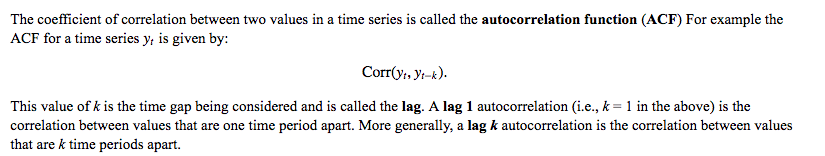

In [2]:
Image("images/autocorrelation.png")

https://onlinecourses.science.psu.edu/stat501/node/358

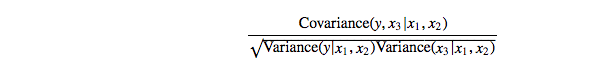

In [3]:
Image("images/partial_correlation.png")

A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

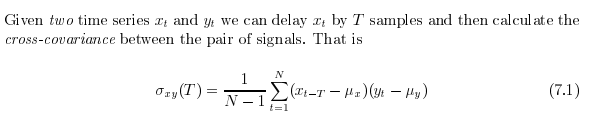

In [4]:
Image("images/cross_correlation.png")

http://www.fil.ion.ucl.ac.uk/~wpenny/course/array.pdf

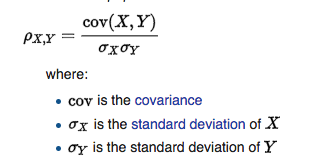

In [5]:
Image("images/pearsoncorrelation.png")

https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

Note: 

- The default in pandas is the Pearson correlation method where it it returns a value between -1 and 1

# Dickey-Fuller Test:

Ho = there is a unit root(there is systematic pattern that is unpredictable)

Ha = Data is stationary (data is predictable/stationary)

If p value is under 0.05, reject Null

https://help.xlstat.com/customer/en/portal/articles/2062423-running-a-unit-root-dickey-fuller-and-stationarity-test-on-a-time-series-with-xlstat?b_id=9283

# 2) EDA and Data Prep

In [6]:
def load(file):
    
    """
    Function to load sensor data
    args:
        file (str): Name of file with data
    returns:
        sensor data of the file
    """
    with open(file, 'r') as f:
        content = f.readlines()
        content = list(map(lambda x: float(x.strip()),content))
    return content

def crosscorr(sensor1, sensor2, lag=40):
    
    """
    cross correlation of two sensors
    args:
        sensor1 (str): first name of sensor to be called
        sensor2 (str): second name of sensor to be called
    returns:
        correlation value between -1 and 1 of the two sensors
    """
    
    s1 = sensor1.split('/')[1]
    s2 = sensor2.split('/')[1]
    
    df = pd.DataFrame(columns=[])
    df[s1] = load(sensor1)
    df[s2] = load(sensor2)
    
    return ((s1,s2),df[s1].corr(df[s2].shift(lag)))

    # https://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas


def sensor_corr(names):
    """
    cross correlation of all sensors against each other
    args:
        names (list): names of the sensors
    returns:
        dictionary of the correlations between each other
    """
    sensor_dict = {}
    for name1 in names:
        for name2 in names:
            if name1 != name2:
                if name1.split("/")[1] not in sensor_dict:
                    sensor_dict[name1.split("/")[1]] = [crosscorr(name1,name2)]
                else:
                    sensor_dict[name1.split("/")[1]].append(crosscorr(name1,name2))
    
    for s in sensor_dict.keys():
        sensor_dict[s] = sorted(sensor_dict[s], key = lambda x : x[1],reverse=True)
    return sensor_dict

### Gathering all the files and fitting all the data into a pandas dataframe

In [7]:
m = glob.glob('data/*')
df = pd.DataFrame(columns=[])

for i in m:
    df[i.split("/")[1]] = load(i)

### Taking a peek at the dataframe

In [8]:
df.head()

,m1,m2,m3,m4,m5,m6,m7,m8,m9
0,1502.0,2886.0,3383.0,629.0,1494.446683,1638.0,1629.0,1776.0,1384.0
1,1478.0,2799.0,3320.0,730.0,1495.038138,1749.0,1912.0,1408.0,1321.0
2,1447.0,2794.0,3346.0,648.0,1477.653175,1677.0,1739.0,1673.0,1347.0
3,1446.0,2783.0,3336.0,625.0,1476.977502,1664.0,1176.0,15.0,1337.0
4,1442.0,2770.0,3326.0,642.0,1430.248249,1691.0,1897.0,1440.0,1328.0


In [9]:
sensor_list = list(df)

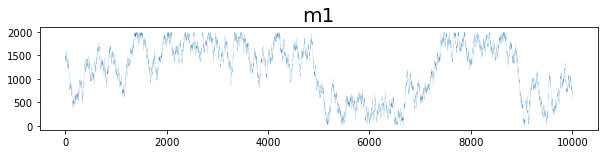

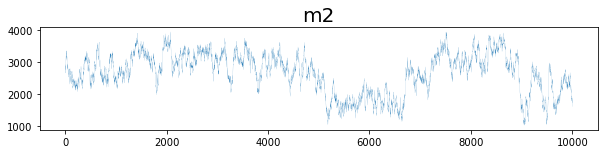

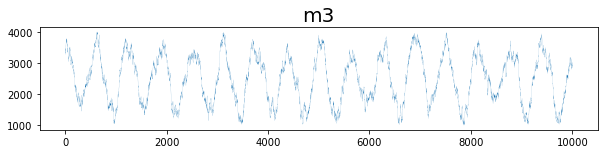

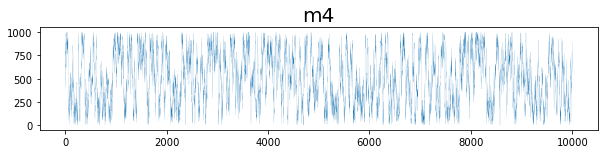

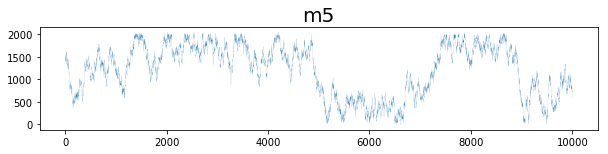

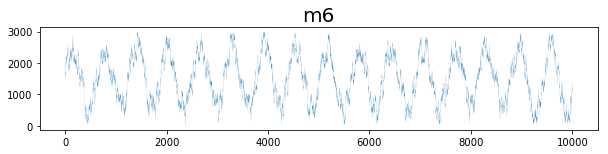

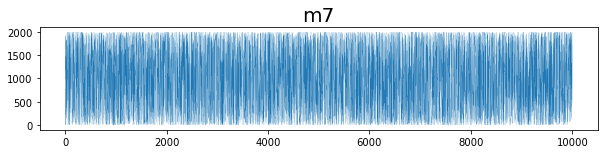

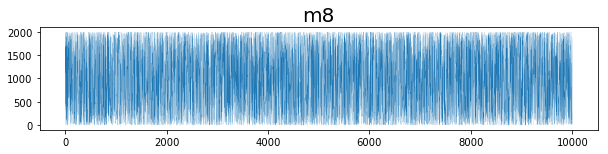

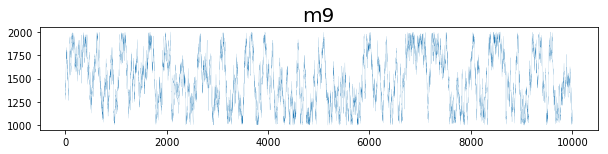

In [10]:
for index,value in enumerate(sensor_list):
    plt.figure(figsize=(10,20))
    plt.subplot(len(list(df)),1,index+1)
    plt.plot(df[value], linewidth=.1)
    plt.title(value,size = 20)

# Checking Distribution with Histogram

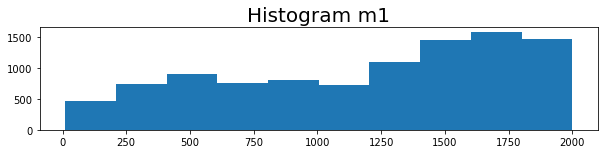

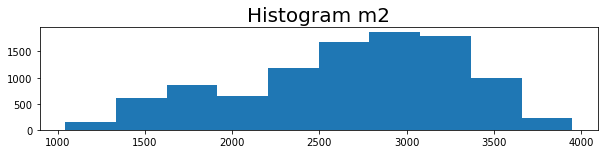

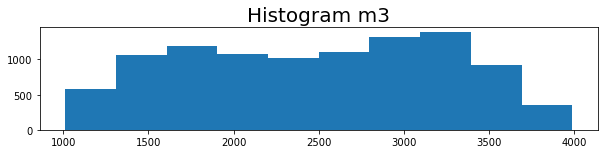

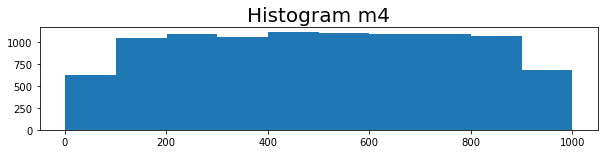

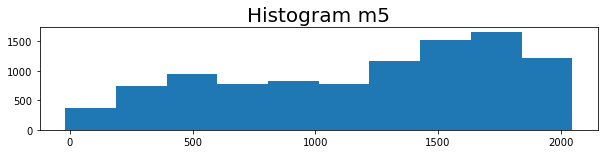

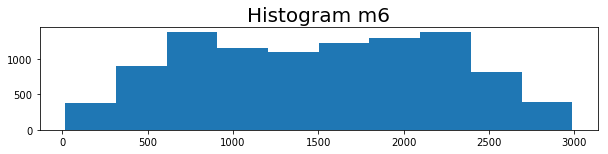

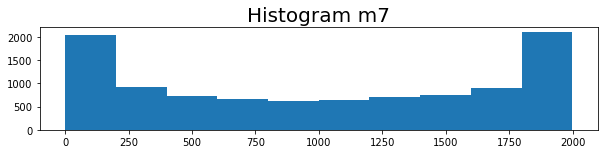

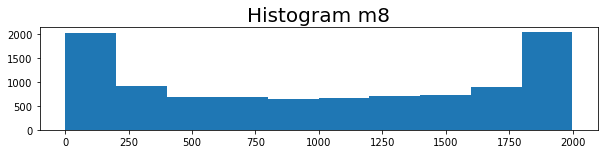

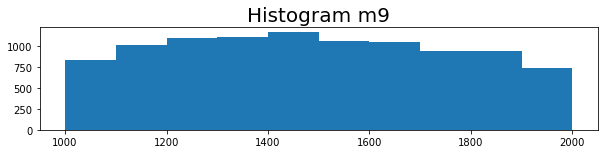

In [11]:
for index, value in enumerate(sensor_list):
    plt.figure(figsize=(10,20))
    plt.subplot(len(list(df)),1,index+1)
    plt.hist(df[value])
    plt.title("Histogram "+ value,size = 20)

# 3) Autocorrelation / Partial AutoCorrelation:
- first, let's look at how each sensor correlates to itself
- I think it is important to understand this before cross-correlating
- check to make sure that the observations at previous time steps are useful to predict the value at the next time step.
- We can demonstrate this with a scatter plot. 

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: 'pandas.tools.plotting.lag_plot' is deprecated, import 'pandas.plotting.lag_plot' instead.
  after removing the cwd from sys.path.


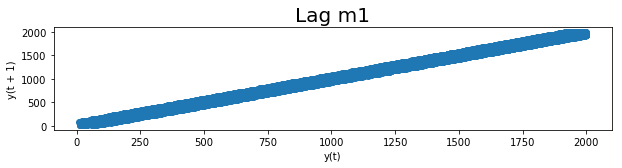

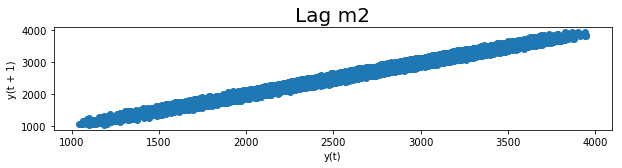

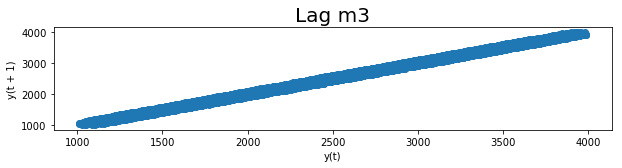

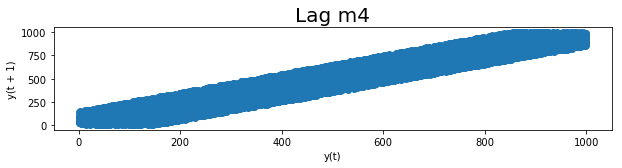

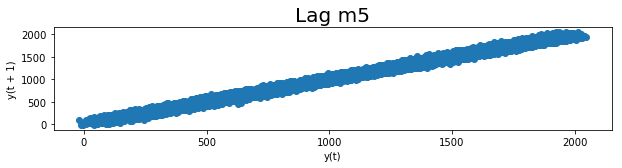

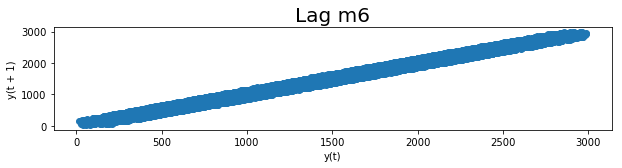

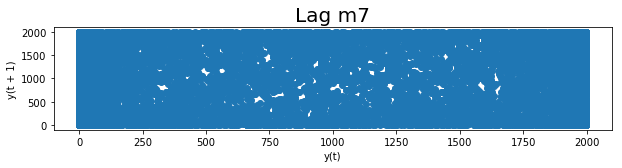

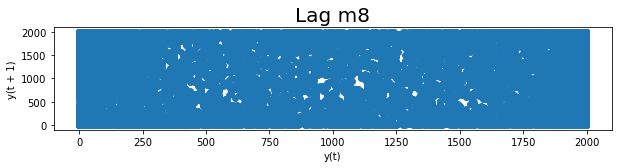

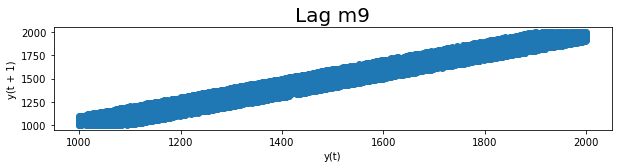

In [12]:
for index, value in enumerate(sensor_list):
    plt.figure(figsize=(10,20))
    plt.subplot(len(list(df)),1,index+1)
    lag_plot(df[value])
    plt.title("Lag "+ value,size = 20)

# Note:
- Except M7 and M8 , it appears that previous values can be used for prediction of the next values with lag
- M7 and M8 the lag correlation is random

# Let's look at how Lag values affect the time series for the first 100 lags:

- The plot also includes solid and dashed lines that indicate the 95% and 99% confidence interval for the correlation values

- Correlation values above these lines are more significant than those below the line, providing a threshold or cutoff for selecting relevant lag values.


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  after removing the cwd from sys.path.


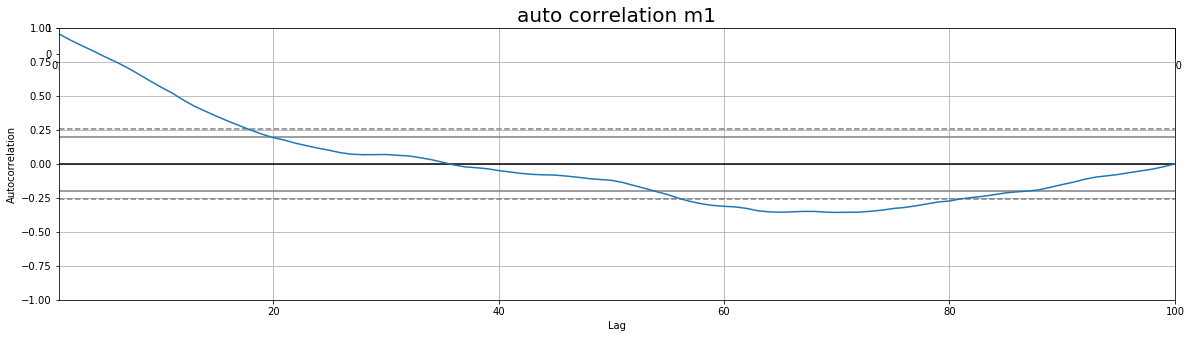

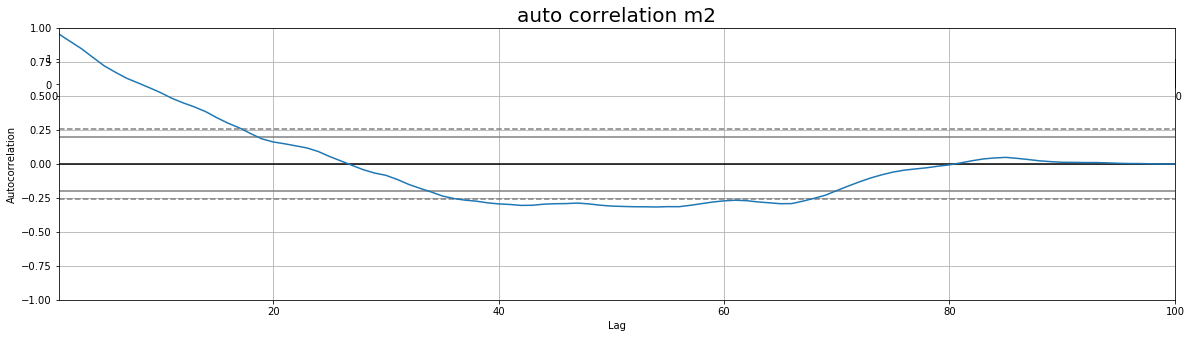

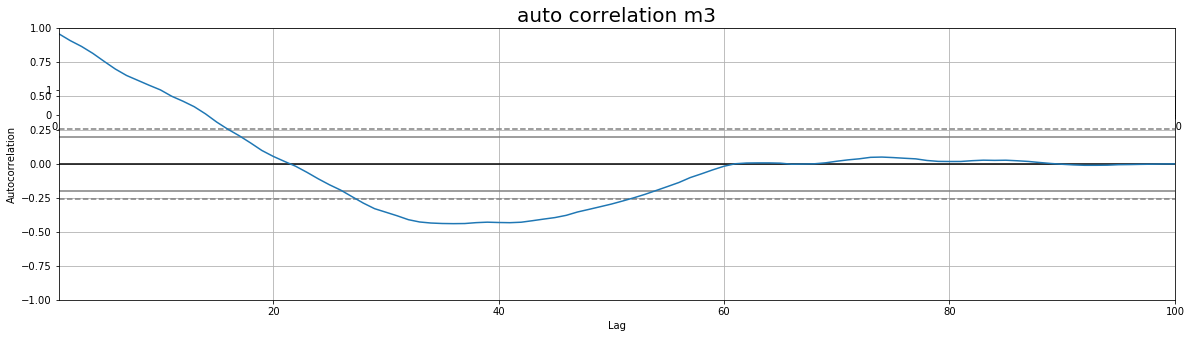

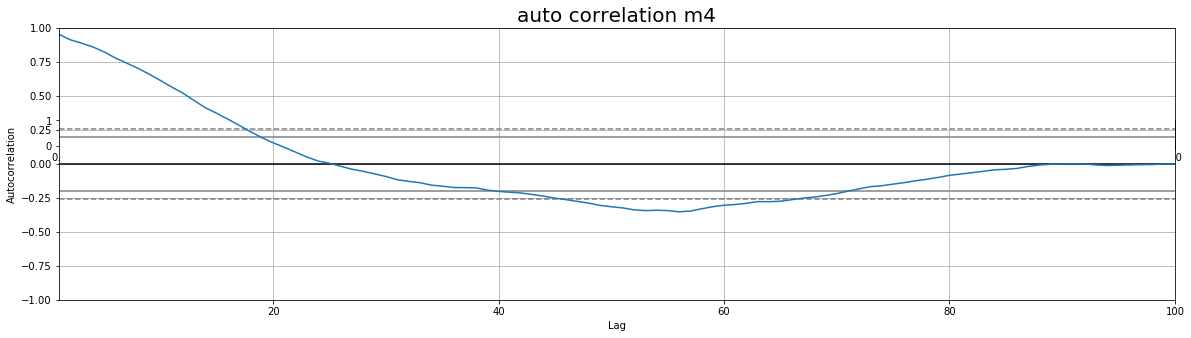

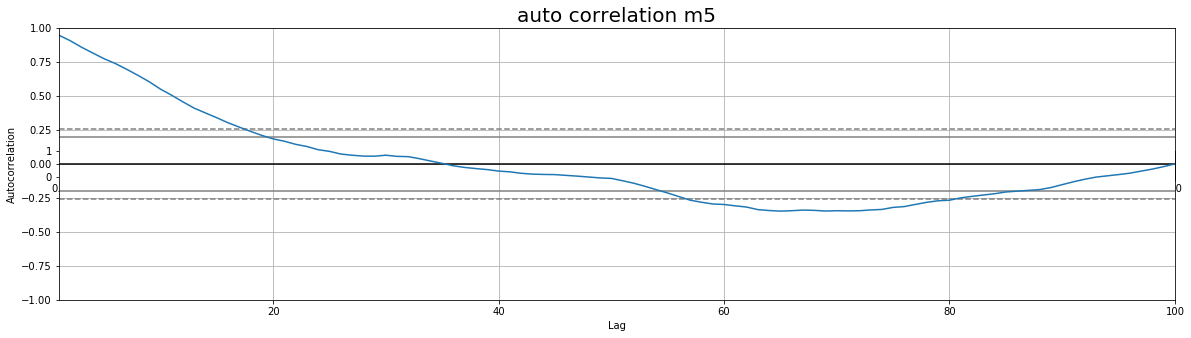

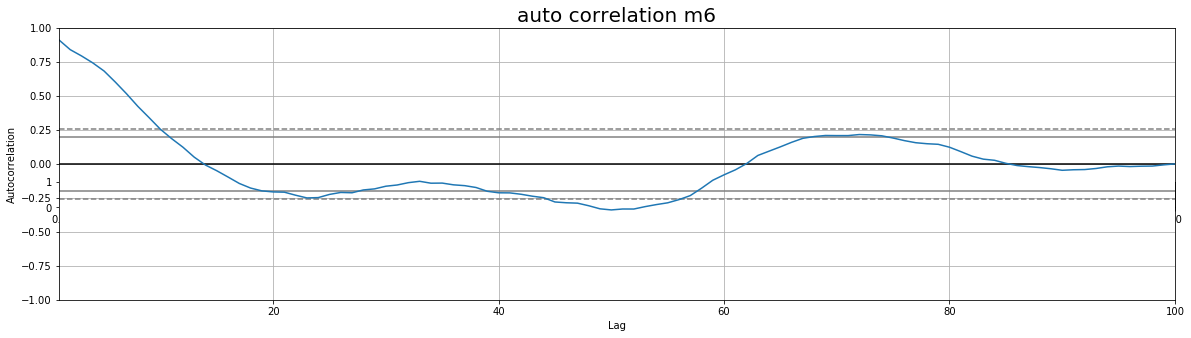

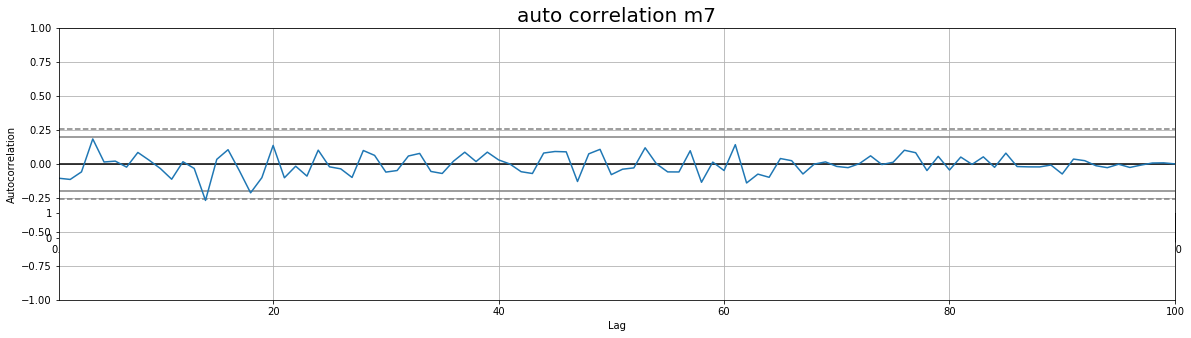

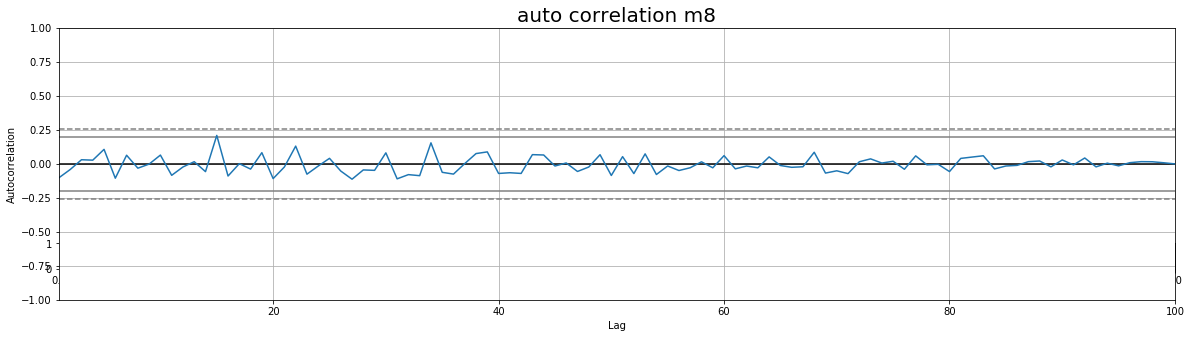

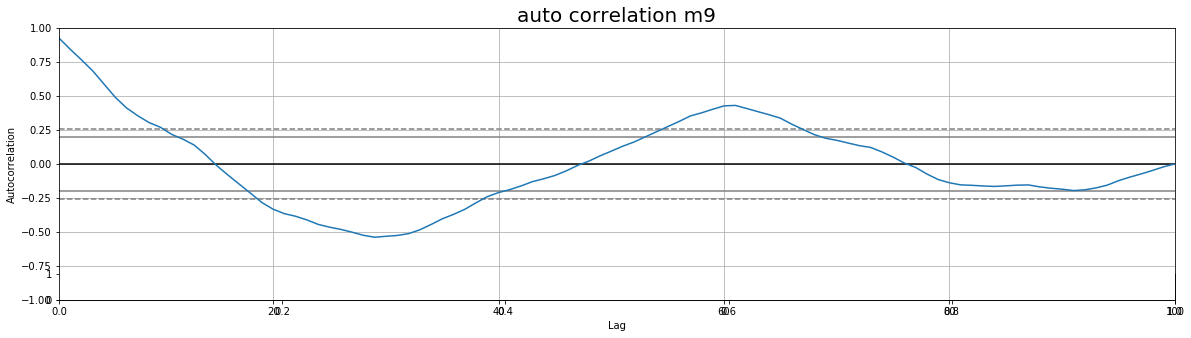

In [13]:
for index, value in enumerate(sensor_list):
    plt.figure(figsize=(20,5))
    plt.subplot(len(list(df)),1,index+1)
    autocorrelation_plot(pd.Series(df[value][:100]))
    plt.title("auto correlation "+ value,size = 20)

Note:
  - Senstor M1,M2,M5 quickly can see a drop and a clear cutoff before the correlation is negative
  - Sensor M4,M7,M8,M9 lag values do not make a difference
  - Sensor M3,M6 the correlation swings back and forth, indicating a seasonal or cyclical pattern
  - Also, since Sensor M3 and M6 have some dampening shape, using the AutoRegressive model should be sufficient for prediction
  -

# Note:
- Based on the graphs, each sensor is highly correlated to itself except for M7 and M8, those to sensors are white noise

# Partial AutoCorrelation for the first 100 lags

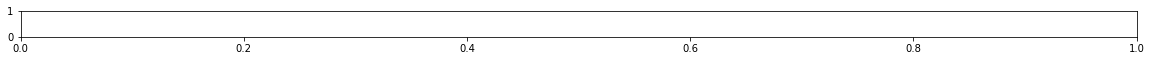

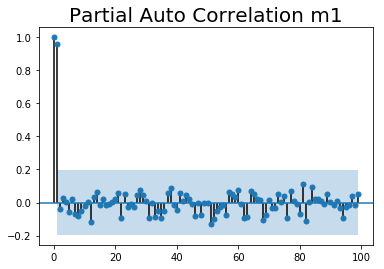

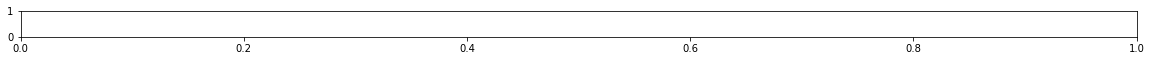

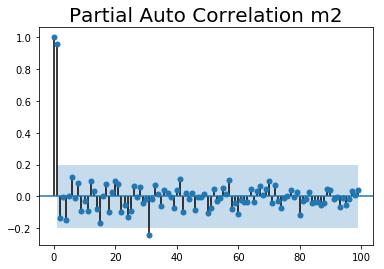

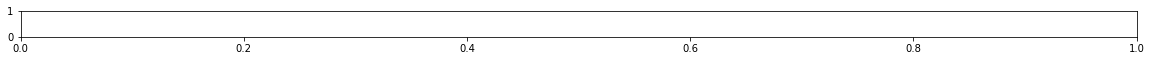

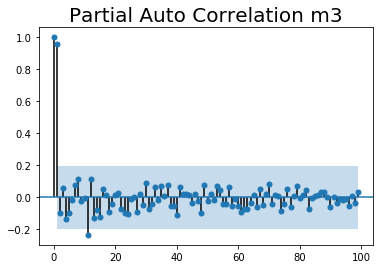

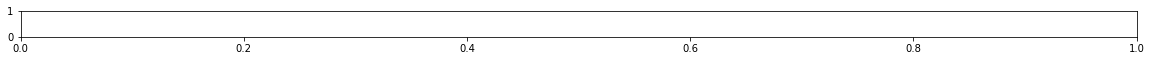

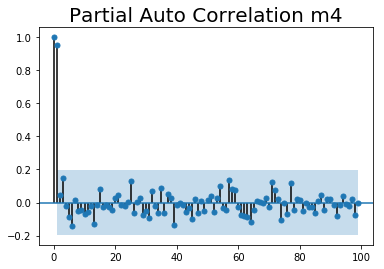

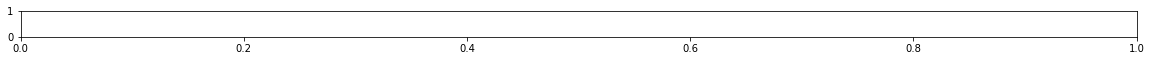

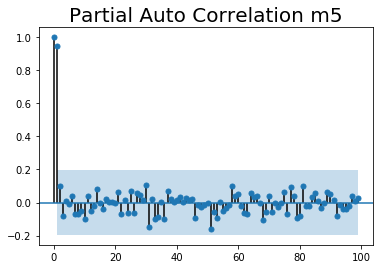

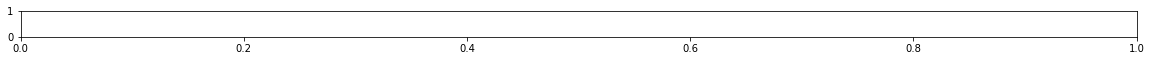

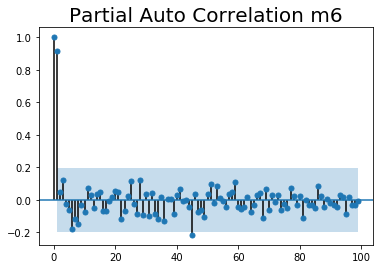

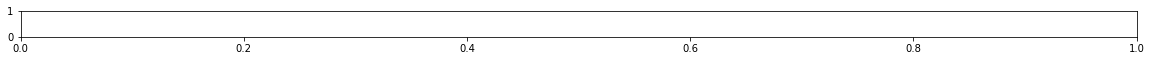

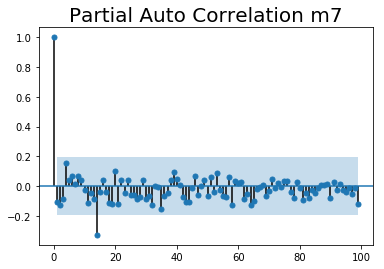

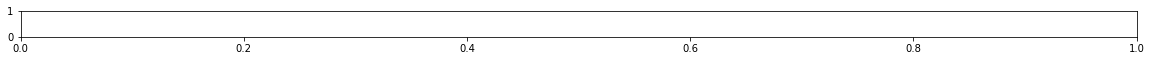

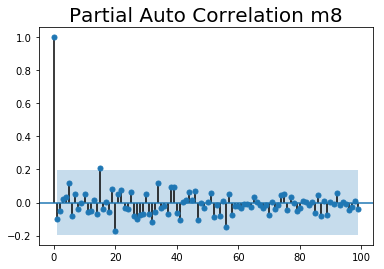

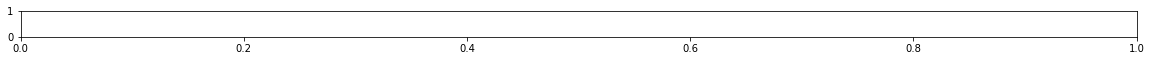

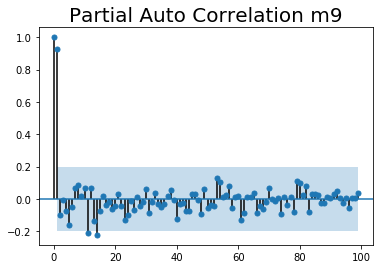

In [14]:
for index, value in enumerate(sensor_list):
    plt.figure(figsize=(20,5))
    plt.subplot(len(list(df)),1,index+1)
    plot_pacf(pd.Series(df[value])[:100])
    plt.title("Partial Auto Correlation "+ value,size = 20)

Note:
- The theoretical PACF “shuts off” past the order of the model
- the plot shows a strong relationship to the lag and trails off of correlation from the lag onwards, which is expected.  
- This indication means that an AutoRegressive Model could be beneficial

https://onlinecourses.science.psu.edu/stat510/node/62
https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

# 4) Lets look at Time Series Data Decomposed

- we do this to break the seasonality(change due to seasons) of the data to find the overall trend

In [15]:
# Adding datetimeindex for the Decomposition to work

df.index = pd.DatetimeIndex(freq = 'w',start = 0 , periods = 10000)

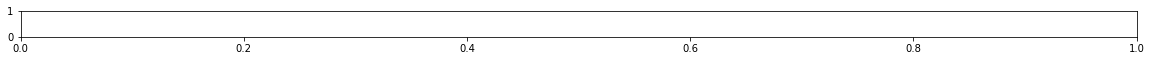

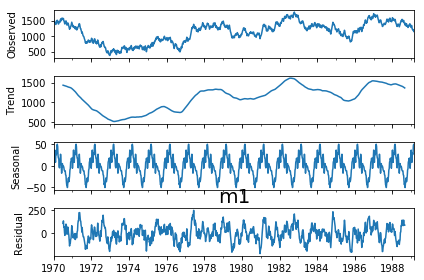

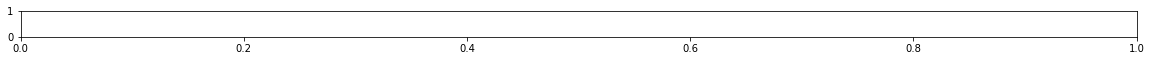

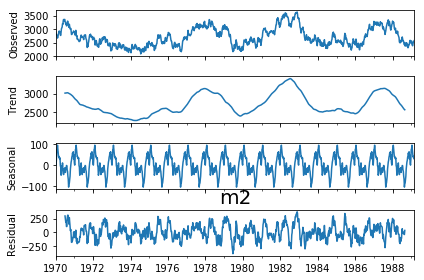

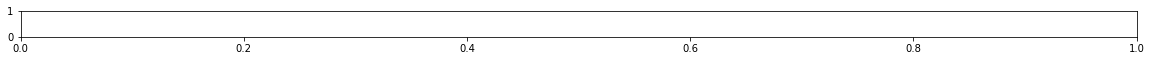

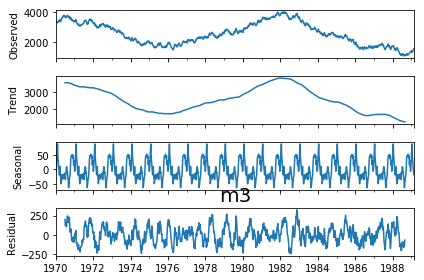

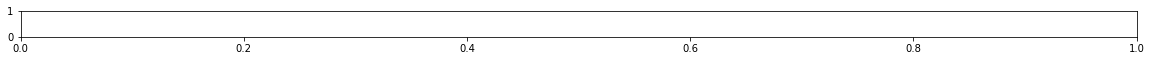

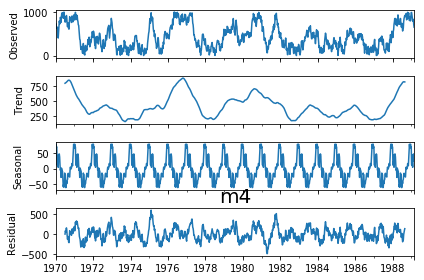

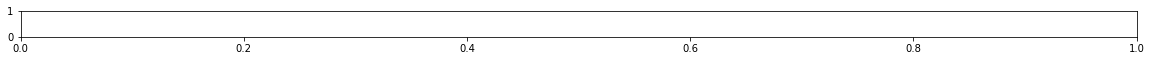

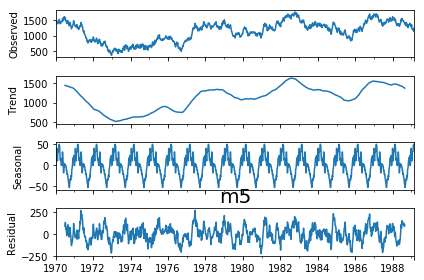

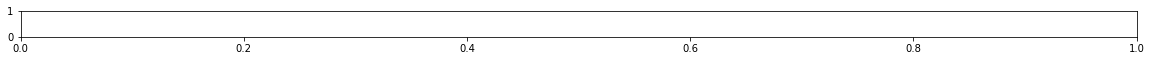

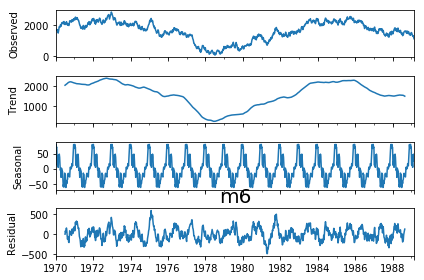

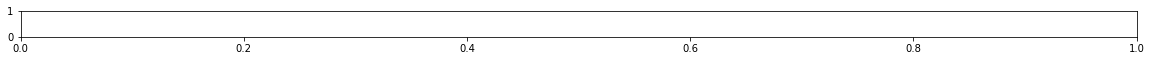

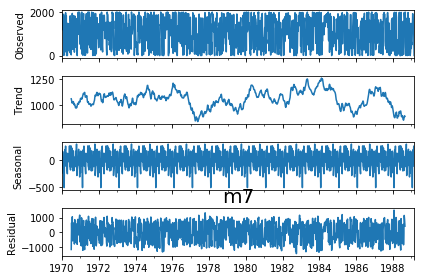

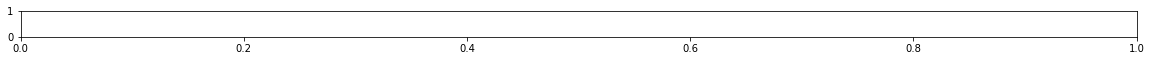

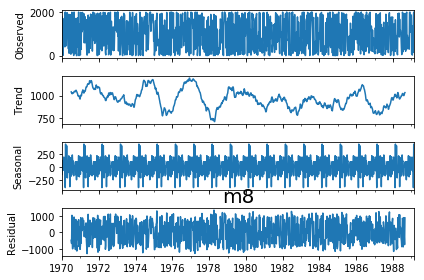

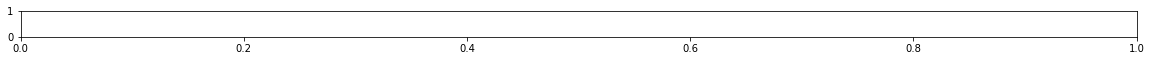

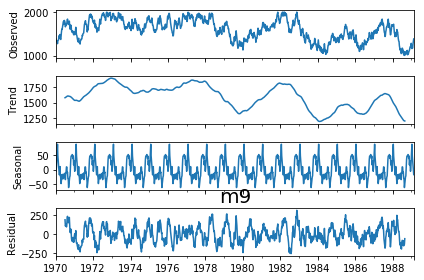

In [16]:
for index, value in enumerate(sensor_list):
    plt.figure(figsize=(20,5))
    plt.subplot(len(list(df)),1,index+1)
    decomposition = seasonal_decompose(df[value][:1000])  
    decomposition.plot()
    plt.title(value,size = 20)


### Note:

- Except M7 and M8 , after decomposing the time series, an overall trend can be established
- M7 and M8 the overall trend does not look like it can be established even after decomposition

In [17]:
def test_stationarity(timeseries,sensor):

    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.title(sensor, size =20)
    plt.legend(loc='best')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
# Original Code is here:

#http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  after removing the cwd from sys.path.


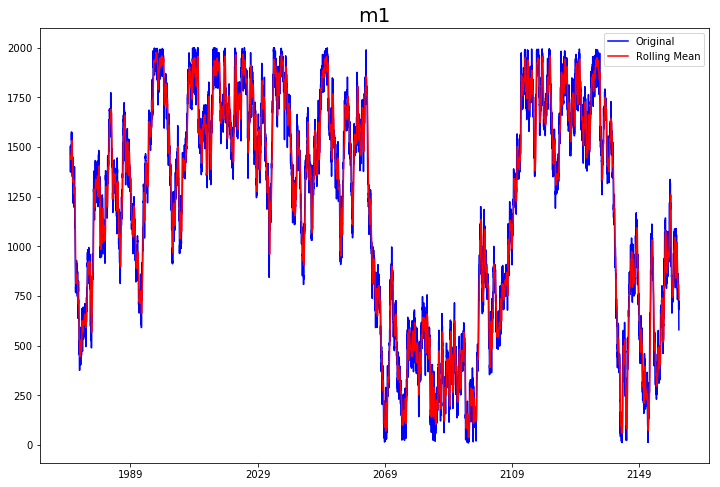

Results of Dickey-Fuller Test:
Test Statistic                   -3.828304
p-value                           0.002631
#Lags Used                        0.000000
Number of Observations Used    9999.000000
Critical Value (1%)              -3.431004
Critical Value (5%)              -2.861829
Critical Value (10%)             -2.566924
dtype: float64


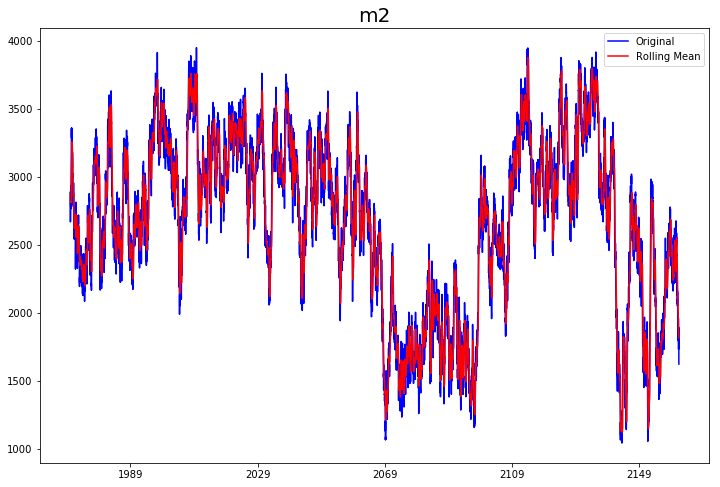

Results of Dickey-Fuller Test:
Test Statistic                   -5.583403
p-value                           0.000001
#Lags Used                        1.000000
Number of Observations Used    9998.000000
Critical Value (1%)              -3.431004
Critical Value (5%)              -2.861829
Critical Value (10%)             -2.566924
dtype: float64


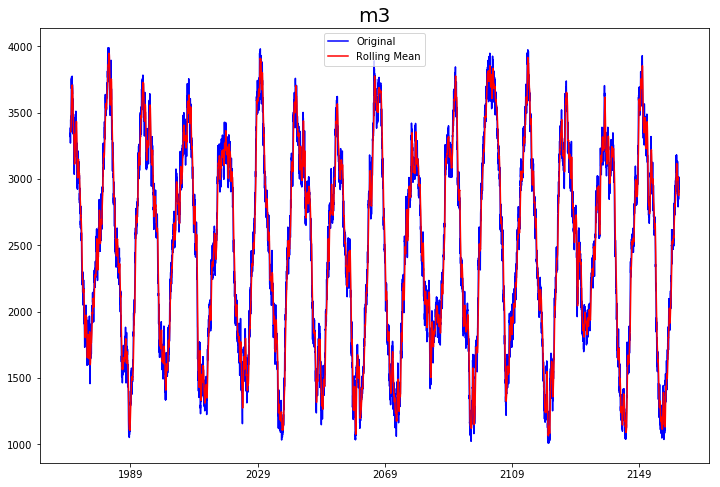

Results of Dickey-Fuller Test:
Test Statistic                   -3.896304
p-value                           0.002062
#Lags Used                        0.000000
Number of Observations Used    9999.000000
Critical Value (1%)              -3.431004
Critical Value (5%)              -2.861829
Critical Value (10%)             -2.566924
dtype: float64


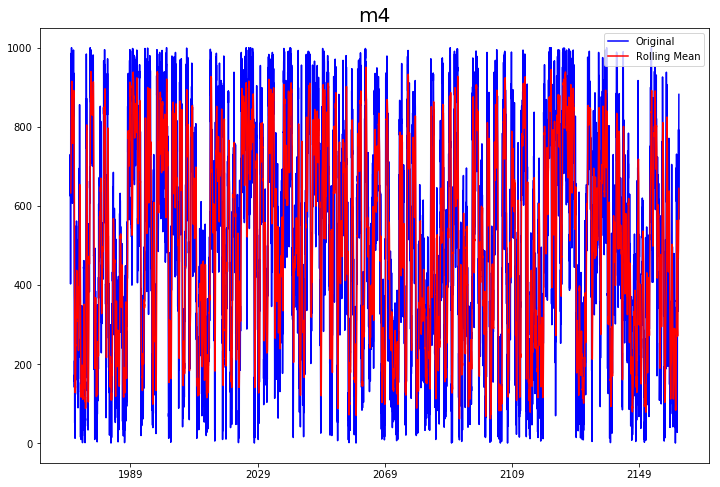

Results of Dickey-Fuller Test:
Test Statistic                -1.477996e+01
p-value                        2.253462e-27
#Lags Used                     2.000000e+00
Number of Observations Used    9.997000e+03
Critical Value (1%)           -3.431004e+00
Critical Value (5%)           -2.861829e+00
Critical Value (10%)          -2.566924e+00
dtype: float64


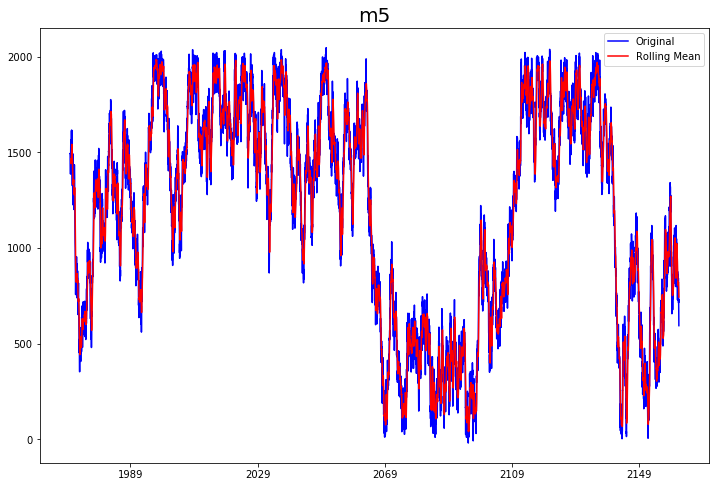

Results of Dickey-Fuller Test:
Test Statistic                   -3.548625
p-value                           0.006823
#Lags Used                        7.000000
Number of Observations Used    9992.000000
Critical Value (1%)              -3.431005
Critical Value (5%)              -2.861829
Critical Value (10%)             -2.566924
dtype: float64


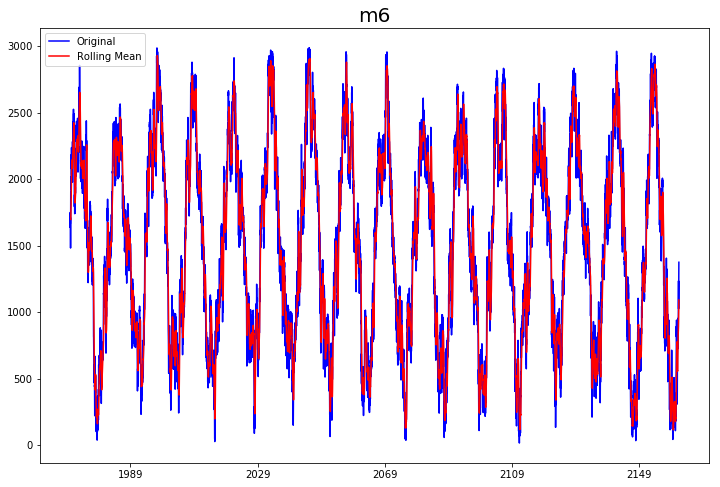

Results of Dickey-Fuller Test:
Test Statistic                   -5.414085
p-value                           0.000003
#Lags Used                        2.000000
Number of Observations Used    9997.000000
Critical Value (1%)              -3.431004
Critical Value (5%)              -2.861829
Critical Value (10%)             -2.566924
dtype: float64


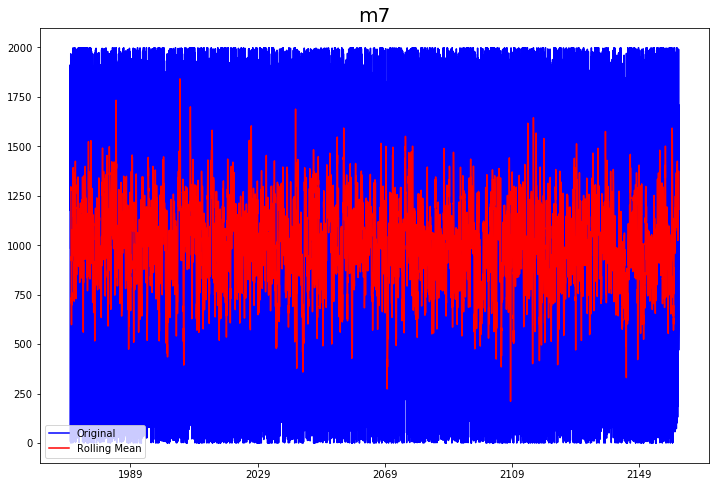

Results of Dickey-Fuller Test:
Test Statistic                 -100.258775
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    9999.000000
Critical Value (1%)              -3.431004
Critical Value (5%)              -2.861829
Critical Value (10%)             -2.566924
dtype: float64


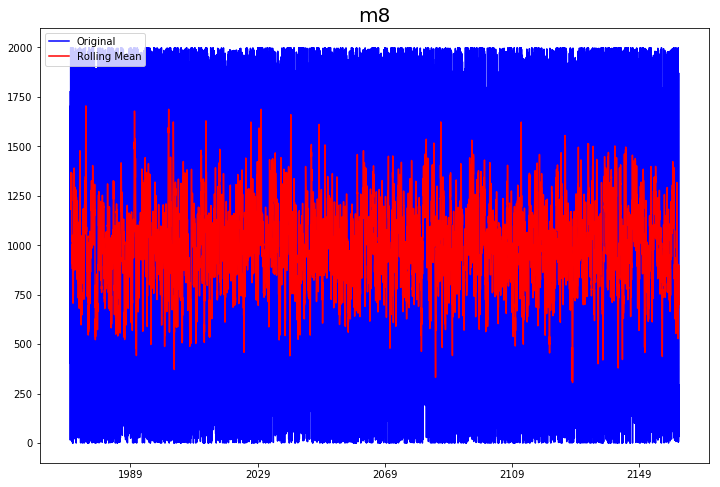

Results of Dickey-Fuller Test:
Test Statistic                  -98.856878
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    9999.000000
Critical Value (1%)              -3.431004
Critical Value (5%)              -2.861829
Critical Value (10%)             -2.566924
dtype: float64


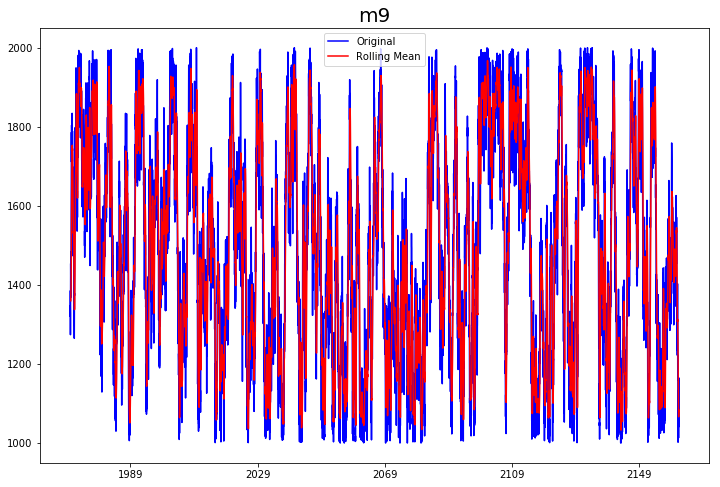

Results of Dickey-Fuller Test:
Test Statistic                -1.028054e+01
p-value                        3.789983e-18
#Lags Used                     1.000000e+00
Number of Observations Used    9.998000e+03
Critical Value (1%)           -3.431004e+00
Critical Value (5%)           -2.861829e+00
Critical Value (10%)          -2.566924e+00
dtype: float64


In [18]:
for sensor in sensor_list:
    test_stationarity(df[sensor],sensor)

### Note:

The augmented Dickey-Fuller statistics are all less than the critical value.  And all the p values are under 0.05, so we can reject the null hypothesis that there is unit root (stochastic/random process) . 

Although the stats look good for M7 and M8, practically I do not fully trust it, and I believe there is still some work to transform the data to become more stationary and predictable

# 3) Cross Correlation:

## Let's look at how each sensor correlates to each other with a correlation matrix:

In [19]:
corr_df = df.corr()
corr_df

,m1,m2,m3,m4,m5,m6,m7,m8,m9
m1,1.000000,0.898479,0.015696,0.161565,0.999356,0.012811,0.025978,-0.002631,0.001275
m2,0.898479,1.000000,0.173979,0.122162,0.897741,-0.042315,0.023284,0.001945,0.440161
m3,0.015696,0.173979,1.000000,-0.003028,0.015123,-0.035954,0.013576,-0.004315,0.364191
m4,0.161565,0.122162,-0.003028,1.000000,0.160934,0.233874,-0.019208,0.017110,-0.052185
m5,0.999356,0.897741,0.015123,0.160934,1.000000,0.012773,0.026156,-0.002597,0.000910
m6,0.012811,-0.042315,-0.035954,0.233874,0.012773,1.000000,-0.010817,-0.010762,-0.122588
m7,0.025978,0.023284,0.013576,-0.019208,0.026156,-0.010817,1.000000,0.016431,-0.000096
m8,-0.002631,0.001945,-0.004315,0.017110,-0.002597,-0.010762,0.016431,1.000000,0.009811
m9,0.001275,0.440161,0.364191,-0.052185,0.000910,-0.122588,-0.000096,0.009811,1.000000


# Let's take a more visual look at it:
Note:
- Looks like M1,M2,M5 are closely correlated to each other:

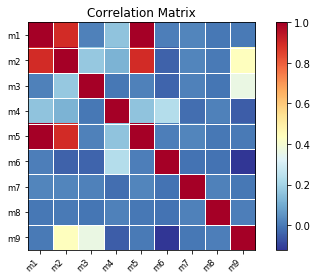

In [20]:
numerics_only = df.select_dtypes(['int64', 'float64'])
sm.graphics.plot_corr(df.corr(), xnames=numerics_only.columns.tolist())
plt.show()

# Store the values at an individual sensor level:

In [21]:
correlated_dict = sensor_corr(m)

Note:
- From the looks of things, M8 is not correlated with any of the other sensors
- the correlation function in pandas can do this as shown earlier, but the sensor_corr function gives me control over the lag, over how much I would like to to look back or forward

In [22]:
for value in list(df):
    pprint.pprint(correlated_dict[value])

[(('m1', 'm5'), 0.90429157421932282),
 (('m1', 'm2'), 0.8057421919244625),
 (('m1', 'm4'), 0.17334096464888474),
 (('m1', 'm7'), 0.02716363146624386),
 (('m1', 'm6'), 0.015148172837386871),
 (('m1', 'm8'), 0.00047704127539285407),
 (('m1', 'm3'), -0.01246549890603188),
 (('m1', 'm9'), -0.01794230910393043)]
[(('m2', 'm1'), 0.80885294147866482),
 (('m2', 'm5'), 0.80802023863618622),
 (('m2', 'm9'), 0.19532413295052334),
 (('m2', 'm4'), 0.15946836373762799),
 (('m2', 'm3'), 0.048868667373390094),
 (('m2', 'm7'), 0.014783336733386032),
 (('m2', 'm8'), -0.0011615462963081168),
 (('m2', 'm6'), -0.027664091320898691)]
[(('m3', 'm9'), 0.2214018553769706),
 (('m3', 'm2'), 0.12561393389322995),
 (('m3', 'm4'), 0.068995968304270433),
 (('m3', 'm1'), 0.031619821453017352),
 (('m3', 'm5'), 0.030871798722630683),
 (('m3', 'm7'), 0.0042769732948718222),
 (('m3', 'm8'), -0.00053092125321352345),
 (('m3', 'm6'), -0.36261239637957532)]
[(('m4', 'm1'), 0.1677355357452128),
 (('m4', 'm5'), 0.167662705578

# Let's take a look at an example of how a change in lag affects cross-correlation between sensors:

- Let's take a look at cross-correlation between M1 and M2, which are highly correlated
- even at the lag increases, the correlation is still high

### Note:

- all the results are normalized between 0 and 1

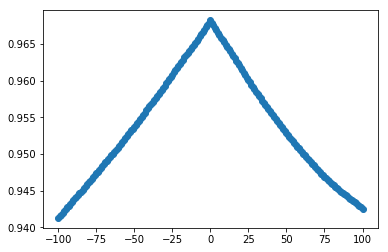

In [23]:
x = df['m1']
y = df['m2']
plt.xcorr(x, y,usevlines=False, maxlags=100, normed=True, lw=1);

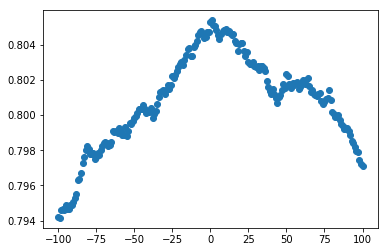

In [24]:
x = df['m9']
y = df['m8']
plt.xcorr(x, y,usevlines=False, maxlags=100, normed=True, lw=1);

# Since M7 and M8 are white noise, there is no clear correlation between each other

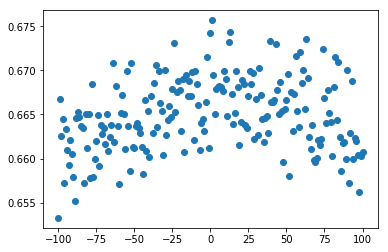

In [25]:
x = df['m7']
y = df['m8']
plt.xcorr(x, y,usevlines=False, maxlags=100, normed=True, lw=1);

# 5) Conclusion/Future Work:

- Noisy sensors such as M7 and M8 would need to be transformed with log , or a smoothing i.e (moving avg,exp smoothing) in order to get a prediction
- M7 and M8 they don't seem to correlation with any sensor so I would assume they are independent functions
- Predictions can be done for most sensors, since the autocorrelation was examined
- some of the modeling techniques that can be used are:
    - ARMA , ARIMA, STL, Median Filter, Markov Chains, Kalman Filter, LSTM networks
- Certain sensors are be shown to have high correlations with others, but need to the know the content behind it, what is driving it
- since there are correlations discovered, multi-variate time series can be done by grouping correlated sensors together for time series prediction
- After predictions, anomaly detection can be implemented in various ways such as standard deviation, using mean squared error, or clustering


In [26]:
# Some References:

# https://matplotlib.org/examples/pylab_examples/xcorr_demo.html
# http://www.lfd.uci.edu/~gohlke/code/ipcf.ipynb.html
# http://www.fil.ion.ucl.ac.uk/~wpenny/course/array.pdf
# https://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas
# https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.signal.correlate.html
# https://plot.ly/python/1d-correlation/https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/
# https://machinelearningmastery.com/white-noise-time-series-python/
# https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/
# http://www.fil.ion.ucl.ac.uk/~wpenny/course/array.pdf
# https://onlinecourses.science.psu.edu/stat501/node/358
# https://en.wikipedia.org/wiki/Pearson_correlation_coefficient
# http://www.cbcity.de/timeseries-decomposition-in-python-with-statsmodels-and-pandas